In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Download Datasets


In [4]:
! kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 98%|████████████████████████████████████████▎| 146M/149M [00:01<00:00, 116MB/s]
100%|█████████████████████████████████████████| 149M/149M [00:01<00:00, 110MB/s]


## Create Annotation Dataframe

In [15]:
def get_class_paths(path):
    classes = []  # List to store class labels
    class_paths = []  # List to store paths to images
    
    # Iterate over each label in the given directory
    for label in os.listdir(path):
        label_path = os.path.join(path, label)  # Construct the full path to the label directory
        
        if os.path.isdir(label_path):  # Check if the path is a directory
            # Iterate over each image in the label directory
            for img in os.listdir(label_path):
                img_path = os.path.join(label_path, img)  # Construct the full path to the image
                
                classes.append(label)  # Append the label to the classes list
                class_paths.append(img_path)  # Append the image path to the class_paths list
    
    # Create a DataFrame with the collected class paths and labels
    df = pd.DataFrame({
        'Class Path': class_paths,
        'Class': classes
    })
    return df  # Return the DataFrame

In [16]:
tr_df = get_class_paths('../data/Training')
tr_df

,Class Path,Class
0,../data/Training/notumor/Tr-no_1480.jpg,notumor
1,../data/Training/notumor/Tr-no_0104.jpg,notumor
2,../data/Training/notumor/Tr-no_1342.jpg,notumor
3,../data/Training/notumor/Tr-no_1298.jpg,notumor
4,../data/Training/notumor/Tr-no_1133.jpg,notumor
...,...,...
5707,../data/Training/glioma/Tr-gl_0454.jpg,glioma
5708,../data/Training/glioma/Tr-gl_0441.jpg,glioma
5709,../data/Training/glioma/Tr-gl_1050.jpg,glioma
5710,../data/Training/glioma/Tr-gl_0307.jpg,glioma


In [17]:
ts_df = get_class_paths('../data/Testing')
ts_df

,Class Path,Class
0,../data/Testing/notumor/Te-no_0346.jpg,notumor
1,../data/Testing/notumor/Te-no_0338.jpg,notumor
2,../data/Testing/notumor/Te-no_0019.jpg,notumor
3,../data/Testing/notumor/Te-no_0096.jpg,notumor
4,../data/Testing/notumor/Te-no_0136.jpg,notumor
...,...,...
1306,../data/Testing/glioma/Te-gl_0024.jpg,glioma
1307,../data/Testing/glioma/Te-gl_0231.jpg,glioma
1308,../data/Testing/glioma/Te-gl_0220.jpg,glioma
1309,../data/Testing/glioma/Te-gl_0277.jpg,glioma


## Visualize Data Distribution

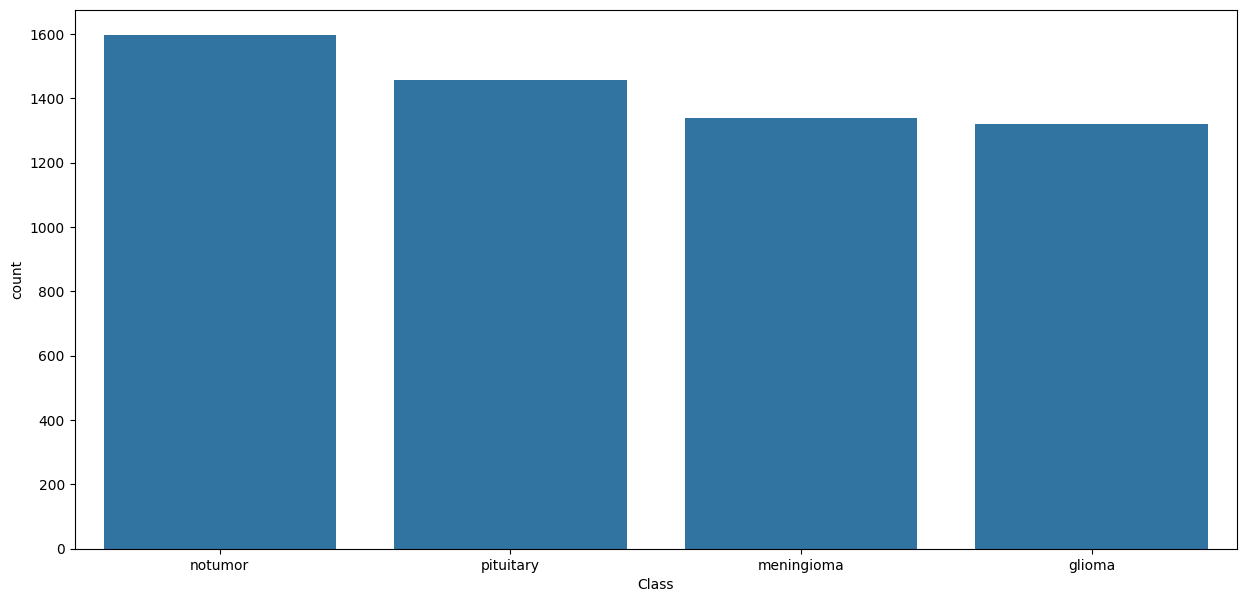

In [18]:
plt.figure(figsize=(15, 7))
ax = sns.countplot(tr_df, x=tr_df['Class'])

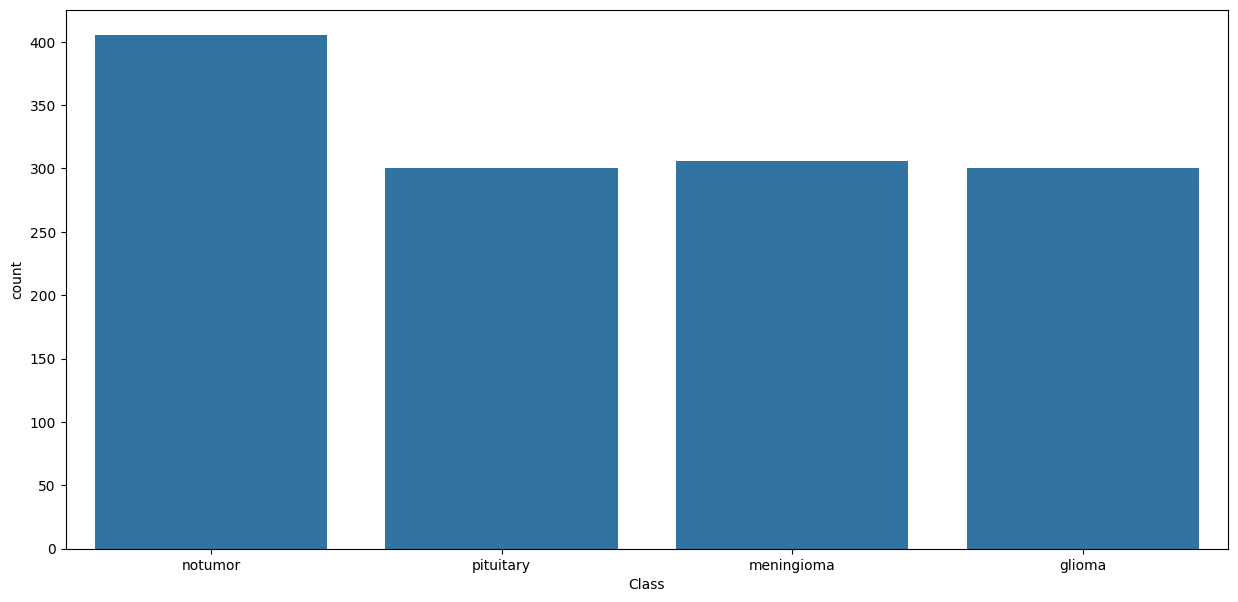

In [19]:
plt.figure(figsize=(15, 7))
ax = sns.countplot(ts_df, x=ts_df['Class'])

## Data Preprocessing

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [21]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, stratify=ts_df["Class"])

In [22]:
valid_df

,Class Path,Class
844,../data/Testing/meningioma/Te-me_0104.jpg,meningioma
1259,../data/Testing/glioma/Te-gl_0276.jpg,glioma
325,../data/Testing/notumor/Te-no_0168.jpg,notumor
1091,../data/Testing/glioma/Te-gl_0262.jpg,glioma
1139,../data/Testing/glioma/Te-gl_0126.jpg,glioma
...,...,...
1090,../data/Testing/glioma/Te-gl_0199.jpg,glioma
1068,../data/Testing/glioma/Te-gl_0187.jpg,glioma
199,../data/Testing/notumor/Te-no_0142.jpg,notumor
150,../data/Testing/notumor/Te-no_0159.jpg,notumor


In [23]:
ts_df

,Class Path,Class
420,../data/Testing/pituitary/Te-pi_0111.jpg,pituitary
1110,../data/Testing/glioma/Te-gl_0079.jpg,glioma
832,../data/Testing/meningioma/Te-me_0103.jpg,meningioma
933,../data/Testing/meningioma/Te-me_0216.jpg,meningioma
686,../data/Testing/pituitary/Te-pi_0093.jpg,pituitary
...,...,...
1057,../data/Testing/glioma/Te-gl_0104.jpg,glioma
438,../data/Testing/pituitary/Te-pi_0161.jpg,pituitary
622,../data/Testing/pituitary/Te-pi_0048.jpg,pituitary
1245,../data/Testing/glioma/Te-gl_0021.jpg,glioma


## Building Model

In [24]:
BATCH_SIZE = 32
IMG_SIZE = (299, 299)
img_gen = ImageDataGenerator(rescale=1/255, brightness_range=(0.8, 1.2))
ts_gen = ImageDataGenerator(rescale=1/255)

In [25]:
tr_gen = img_gen.flow_from_dataframe(tr_df, x_col="Class Path",
                                     y_col="Class",
                                     batch_size=BATCH_SIZE,
                                     target_size=IMG_SIZE)

valid_gen = img_gen.flow_from_dataframe(valid_df, x_col="Class Path",
                                        y_col="Class",
                                        batch_size=BATCH_SIZE,
                                        target_size=IMG_SIZE)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col="Class Path",
                                     y_col="Class",
                                     batch_size=16,
                                     target_size=IMG_SIZE, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


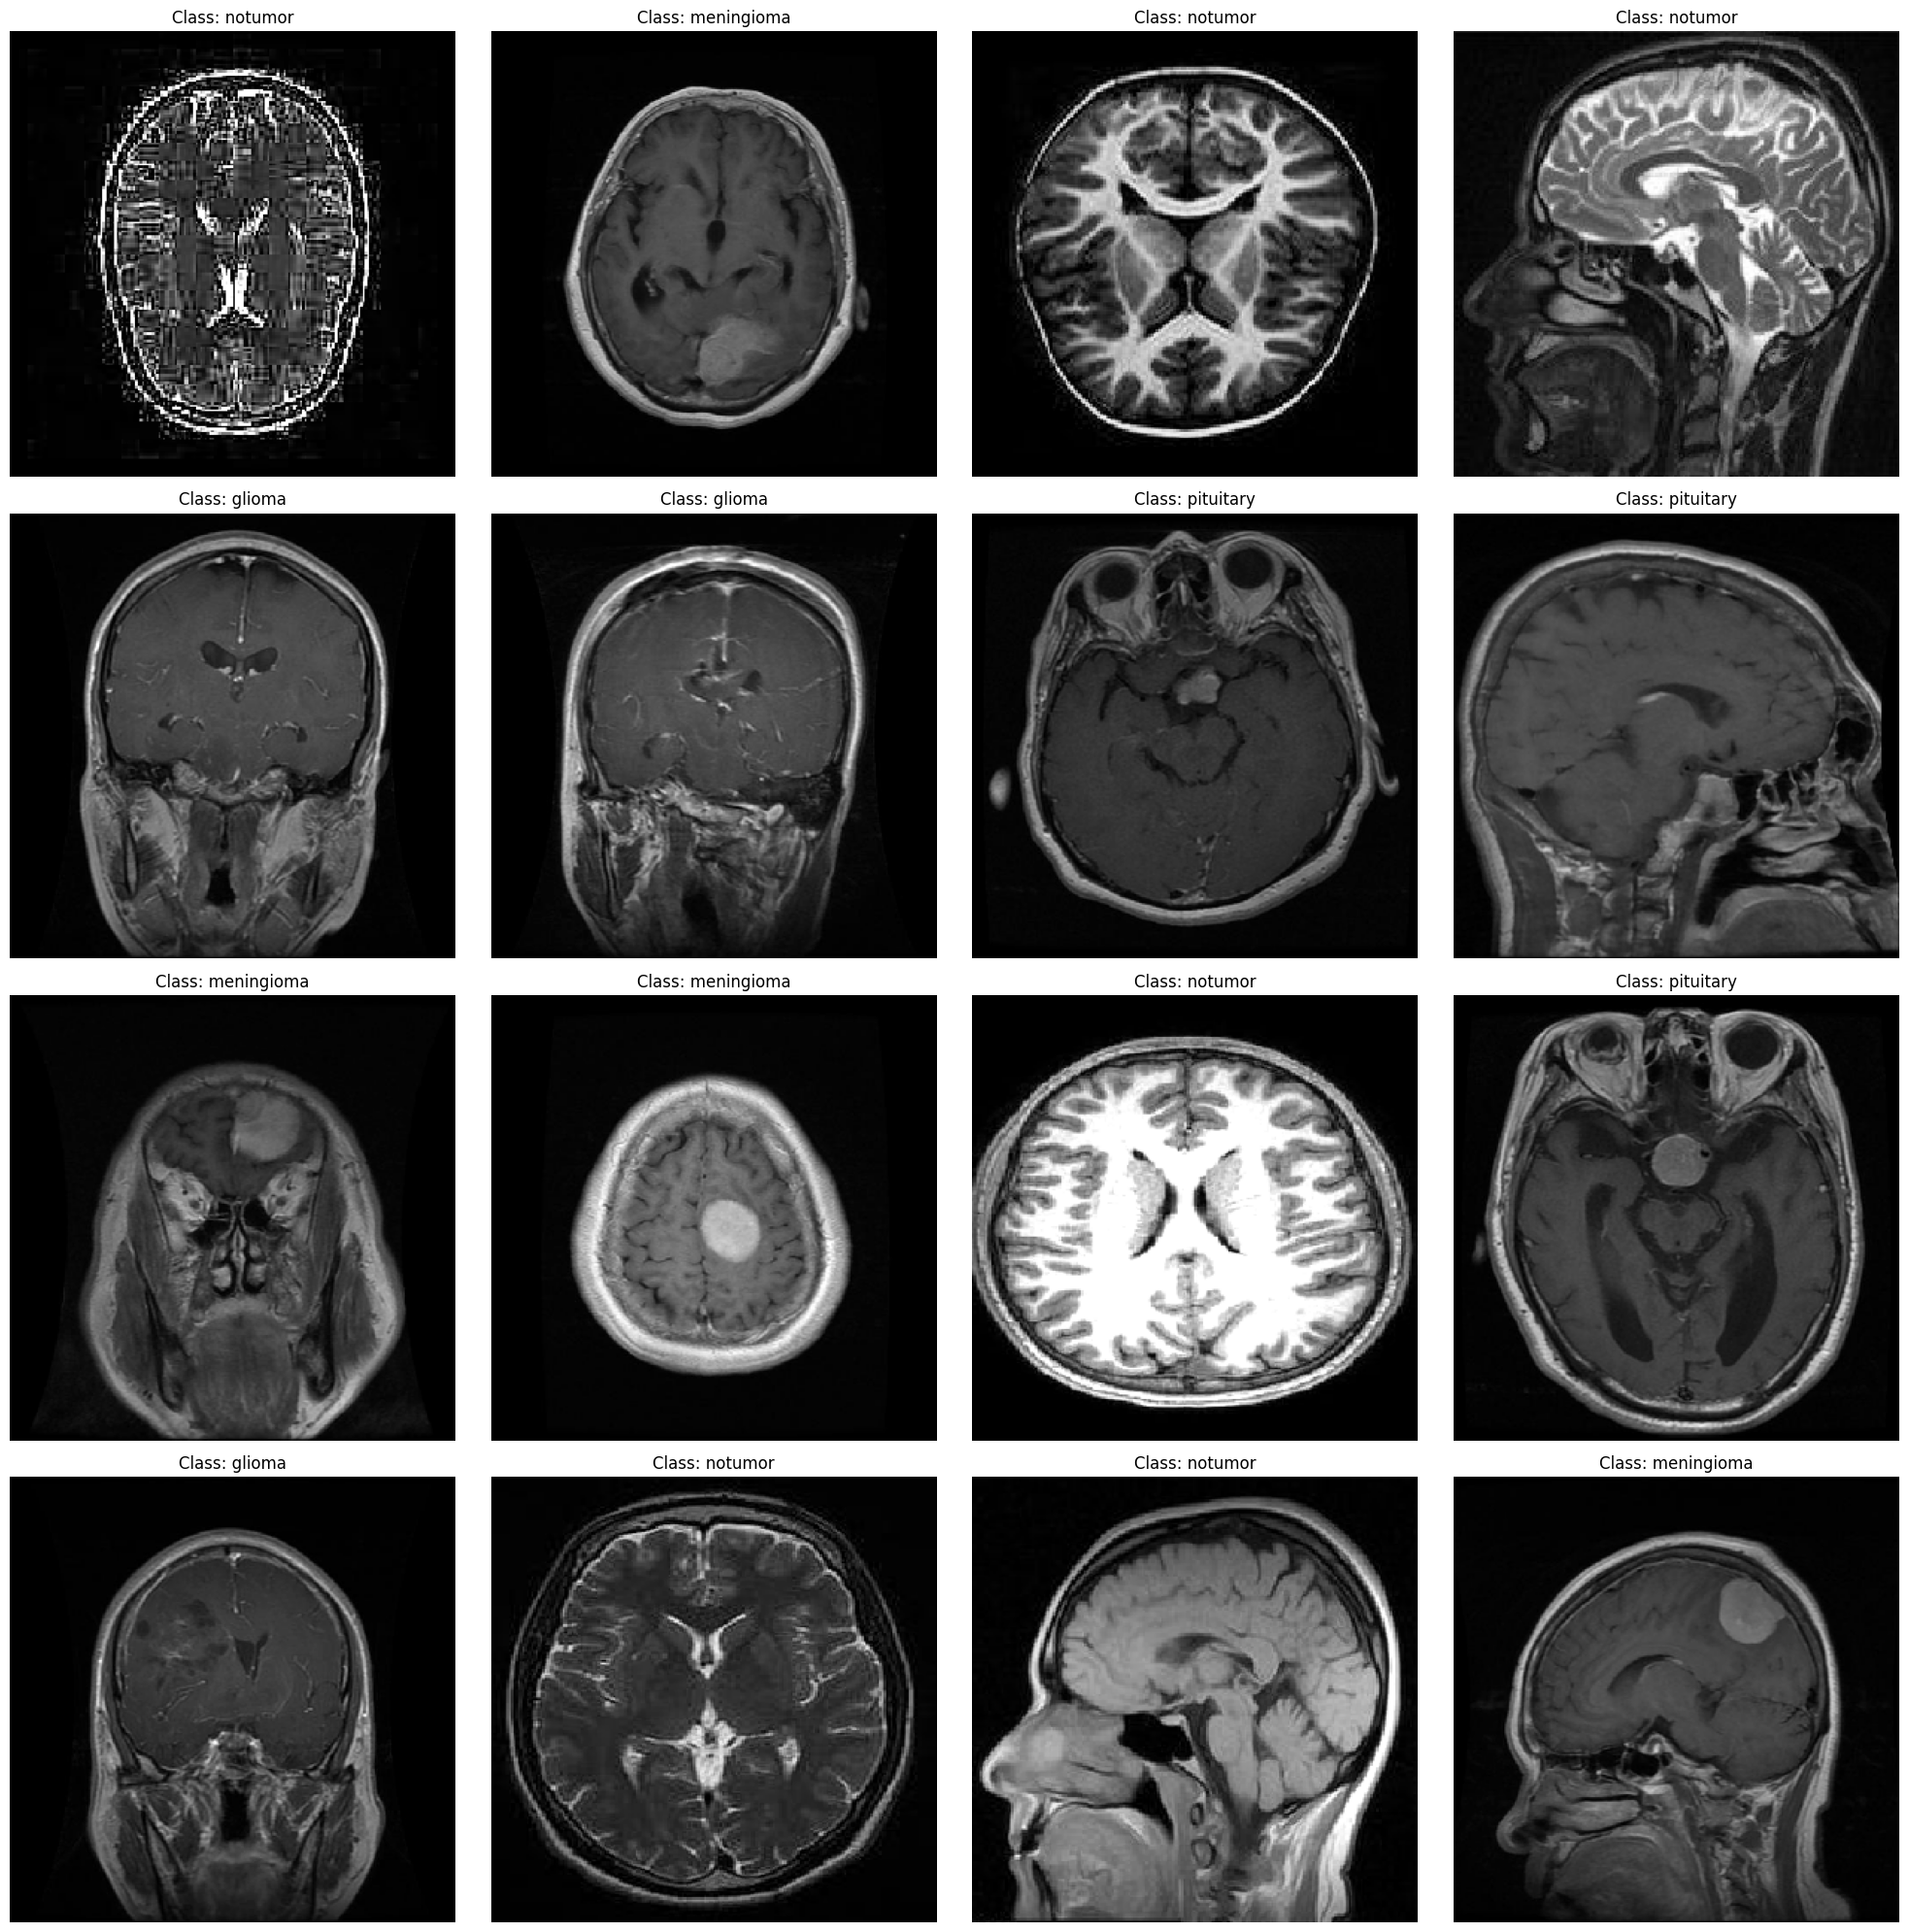

In [26]:
plt.figure(figsize=(20,20))
for i in range(16):
    plt.subplot(4,4,i+1)
    batch = next(tr_gen)
    image = batch[0][0]
    label = batch[1][0]
    plt.imshow(image)
    
    class_index = np.argmax(label)
    class_names = list(tr_gen.class_indices.keys())
    class_indices = list(tr_gen.class_indices.values())
    
    index_position = class_indices.index(class_index)
    class_name = class_names[index_position]
    
    plt.title(f"Class: {class_name}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# Define the shape of the input images
img_shape = (299,299, 3)

# Load the Xception model pre-trained on ImageNet, excluding the top layer
base_model = tf.keras.applications.Xception(include_top=False,
                                            weights="imagenet",
                                            input_shape=img_shape,
                                            pooling='max')

# Create a Sequential model
model = Sequential([
    base_model,  # Add the base model
    Flatten(),  # Flatten the output of the base model
    Dropout(rate=0.3),  # Add a dropout layer with a rate of 0.3
    Dense(128, activation='relu'),  # Add a dense layer with 128 units and ReLU activation
    Dropout(rate=0.25),  # Add another dropout layer with a rate of 0.25
    Dense(4, activation='softmax')  # Add a dense layer with 4 units and softmax activation for classification
])

I0000 00:00:1731340334.528742   24830 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9517 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:02:00.0, compute capability: 8.9


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Compile the model with Adamax optimizer, categorical crossentropy loss, and accuracy, precision, and recall metrics
model.compile(Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

## Training Model

In [30]:
hist = model.fit(tr_gen, epochs=5, validation_data=valid_gen)

/home/luisruiz720/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1731340884.510154   50803 service.cc:148] XLA service 0x7feec4002b10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731340884.511093   50803 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2024-11-11 09:01:25.604044: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731340887.547108   50803 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1731340894.149493   50803 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731340894.272569   50803 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731340894.398666  

177/179 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.7561 - loss: 0.8080 - precision: 0.8166 - recall: 0.6633

E0000 00:00:1731340956.198483   50803 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731340956.322454   50803 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-11-11 09:02:37.639464: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 17.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
E0000 00:00:1731340961.661138   50803 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731340961.784175   50803 gpu_timer.cc:82] Delay kernel timed out: measured ti

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.7573 - loss: 0.8033 - precision: 0.8177 - recall: 0.6652

E0000 00:00:1731340977.395025   50802 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731340977.522533   50802 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-11-11 09:02:58.594232: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 17.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


179/179 ━━━━━━━━━━━━━━━━━━━━ 107s 360ms/step - accuracy: 0.7580 - loss: 0.8010 - precision: 0.8182 - recall: 0.6662 - val_accuracy: 0.9206 - val_loss: 0.2360 - val_precision: 0.9331 - val_recall: 0.9160
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 38s 213ms/step - accuracy: 0.9746 - loss: 0.0739 - precision: 0.9758 - recall: 0.9731 - val_accuracy: 0.9542 - val_loss: 0.1372 - val_precision: 0.9585 - val_recall: 0.9511
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 38s 214ms/step - accuracy: 0.9910 - loss: 0.0298 - precision: 0.9912 - recall: 0.9910 - val_accuracy: 0.9481 - val_loss: 0.1738 - val_precision: 0.9481 - val_recall: 0.9481
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 38s 213ms/step - accuracy: 0.9884 - loss: 0.0352 - precision: 0.9889 - recall: 0.9883 - val_accuracy: 0.9511 - val_loss: 0.2881 - val_precision: 0.9526 - val_recall: 0.9511
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 38s 213ms/step - accuracy: 0.9944 - loss: 0.0160 - precision: 0.9946 - recall: 0.9944 - val_accuracy: 0.9817 - val_loss: 0

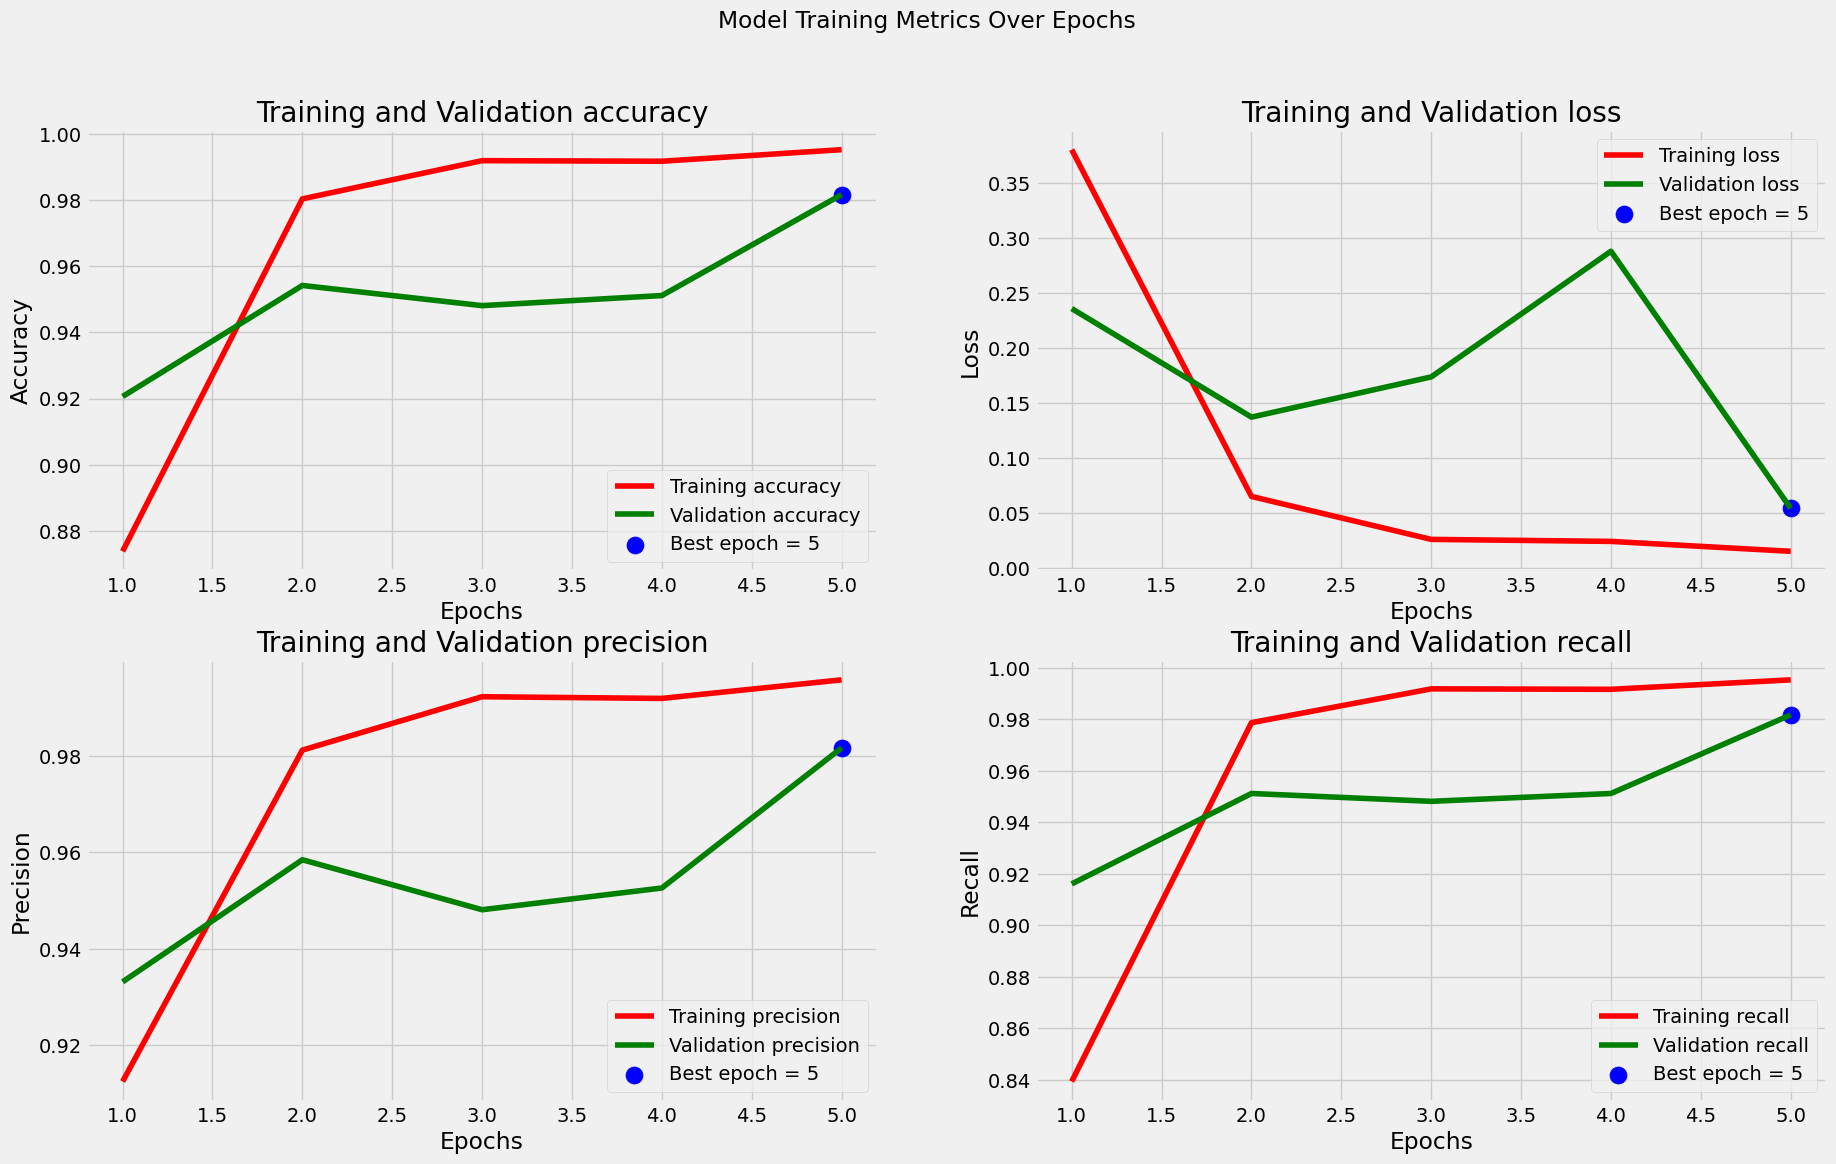

In [37]:
# Define the metrics to be tracked
metrics = ["accuracy", "loss", "precision", "recall"]


def plot_training_metrics(hist, metrics):
    # Extract training metrics from the history object
    tr_metrics = {m: hist.history[m] for m in metrics}

    # Extract validation metrics from the history object
    val_metrics = {m: hist.history[f"val_{m}"] for m in metrics}

    # Initialize dictionaries to store the best epochs and their corresponding values
    best_epochs = {}
    best_values = {}

    # Iterate over each metric to find the best epoch and its value
    for m in metrics:
        if m == 'loss':
            # For loss, the best epoch is the one with the minimum value
            idx = np.argmin(val_metrics[m])
        else:
            # For other metrics, the best epoch is the one with the maximum value
            idx = np.argmax(val_metrics[m])
        best_epochs[m] = idx + 1  # Store the best epoch (1-based index)
        best_values[m] = val_metrics[m][idx]  # Store the best value

    # Create a figure for plotting
    plt.figure(figsize=(20,12))

    # Set the style for the plots
    plt.style.use('fivethirtyeight')

    # Iterate over each metric to create subplots
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)  # Create a subplot
        epochs = range(1, len(tr_metrics[metric]) + 1)  # Define the range of epochs

        # Plot training metrics
        plt.plot(epochs, tr_metrics[metric], 'r', label=f'Training {metric}')

        # Plot validation metrics
        plt.plot(epochs, val_metrics[metric], 'g', label=f'Validation {metric}')

        # Highlight the best epoch with a scatter plot
        plt.scatter(best_epochs[metric], best_values[metric], s=150, c='blue',
                    label=f"Best epoch = {best_epochs[metric]}")

        # Set the title and labels for the subplot
        plt.title(f'Training and Validation {metric}')
        plt.xlabel("Epochs")
        plt.ylabel(metric.title())
        plt.legend()  # Add a legend
        plt.grid(True)  # Enable grid

    # Set the main title for the figure
    plt.suptitle("Model Training Metrics Over Epochs")

    # Display the plots
    plt.show()

# Call the function to plot the metrics
plot_training_metrics(hist, metrics)

In [42]:
hist2 = model.fit(tr_gen, epochs=6, validation_data=valid_gen)

Epoch 1/6
179/179 ━━━━━━━━━━━━━━━━━━━━ 39s 220ms/step - accuracy: 0.9995 - loss: 0.0044 - precision: 0.9995 - recall: 0.9995 - val_accuracy: 0.9817 - val_loss: 0.1372 - val_precision: 0.9817 - val_recall: 0.9817
Epoch 2/6
179/179 ━━━━━━━━━━━━━━━━━━━━ 39s 215ms/step - accuracy: 0.9970 - loss: 0.0074 - precision: 0.9970 - recall: 0.9967 - val_accuracy: 0.9939 - val_loss: 0.0554 - val_precision: 0.9939 - val_recall: 0.9939
Epoch 3/6
179/179 ━━━━━━━━━━━━━━━━━━━━ 39s 215ms/step - accuracy: 0.9976 - loss: 0.0084 - precision: 0.9976 - recall: 0.9976 - val_accuracy: 0.9939 - val_loss: 0.0601 - val_precision: 0.9939 - val_recall: 0.9939
Epoch 4/6
179/179 ━━━━━━━━━━━━━━━━━━━━ 39s 215ms/step - accuracy: 0.9990 - loss: 0.0021 - precision: 0.9990 - recall: 0.9990 - val_accuracy: 0.9924 - val_loss: 0.0568 - val_precision: 0.9924 - val_recall: 0.9924
Epoch 5/6
179/179 ━━━━━━━━━━━━━━━━━━━━ 39s 215ms/step - accuracy: 0.9998 - loss: 0.0022 - precision: 0.9998 - recall: 0.9998 - val_accuracy: 0.9939 - va

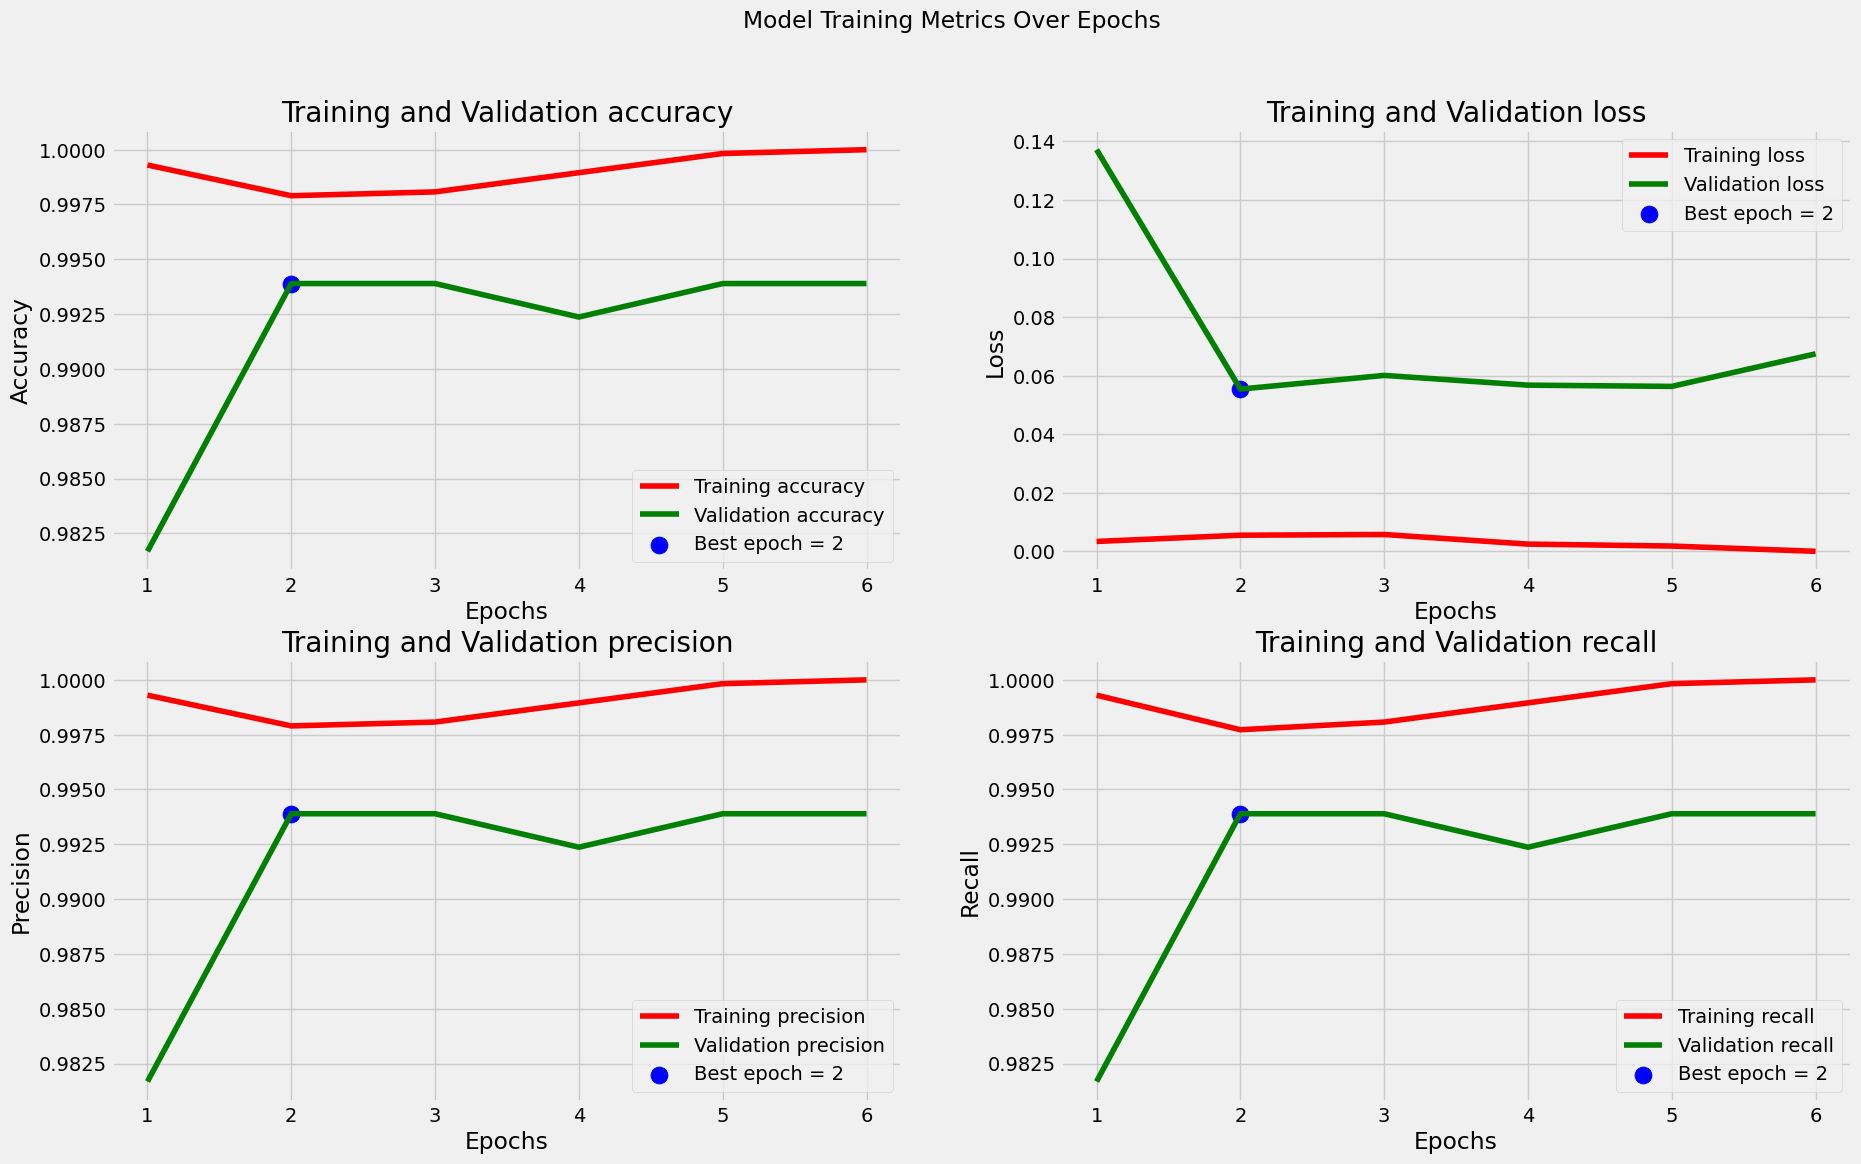

In [45]:
plot_training_metrics(hist2, metrics)

## Evaluation

In [46]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print(f"Train Loss: {train_score[0]*100:.4f}%")
print(f"\n\nValidation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Validation Loss: {valid_score[0]:.4f}%")
print(f"\n\nTest Accuracy: {test_score[1]*100:.2f}%")
print(f"Test Loss: {test_score[0]:.4f}%")

179/179 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - accuracy: 1.0000 - loss: 1.6581e-06 - precision: 1.0000 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9968 - loss: 0.0152 - precision: 0.9968 - recall: 0.9968
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9957 - loss: 0.0218 - precision: 0.9957 - recall: 0.9957
Train Accuracy: 100.00%
Train Loss: 0.0002%


Validation Accuracy: 99.39%
Validation Loss: 0.0684%


Test Accuracy: 99.24%
Test Loss: 0.0504%


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


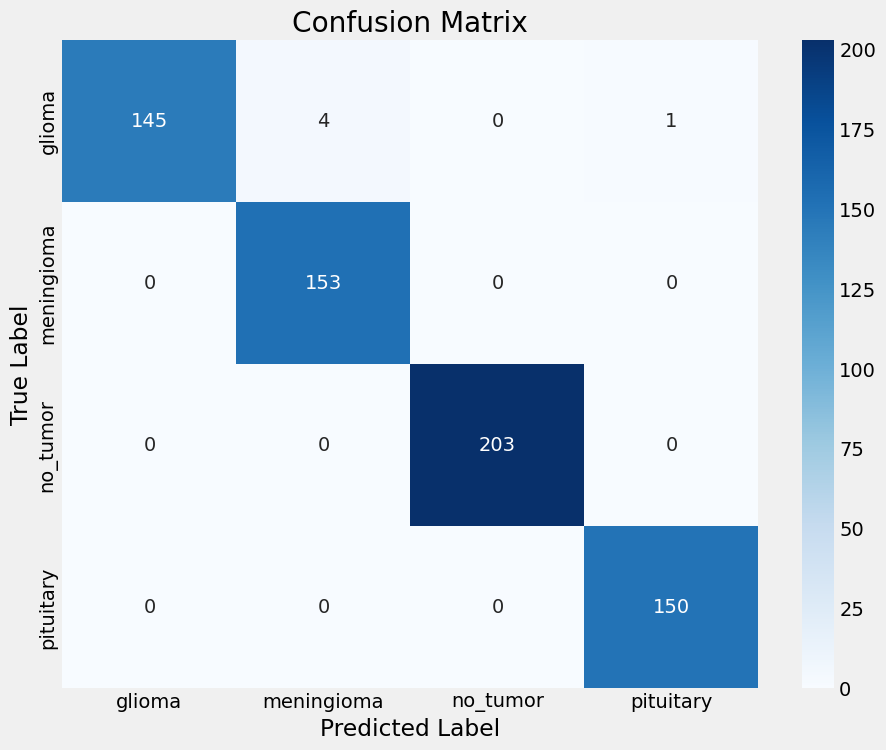

In [47]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

class_dict = {
    0: "glioma",
    1: "meningioma",
    2: "no_tumor",
    3: "pituitary"
}

cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.values())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [56]:
from PIL import Image

def predict(img_path: str) -> None:
    labels = list(class_dict.values())
    plt.figure(figsize=(6,8))
    
    img = Image.open(img_path)
    resized_img = img.resize((299,299))
    img_array = np.asarray(resized_img)
    img_array = np.expand_dims(img_array, axis=0)/255.0
    
    predictions = model.predict(img_array)
    probabilities = list(predictions[0])
    
    predicted_class_idx = np.argmax(probabilities)
    predicted_class = class_dict[predicted_class_idx]
    
    plt.subplot(2,1,1)
    plt.imshow(resized_img)
    plt.title(f"Input MRI Image\nPredicted: {predicted_class}")
    
    plt.subplot(2,1,2)
    bars = plt.barh(labels, probabilities)
    plt.xlabel("Probability", fontsize=15)
    plt.title("Class Probabilities")
    
    ax = plt.gca()
    ax.bar_label(bars, fmt="%.2f")
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nPredicted tumor type: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


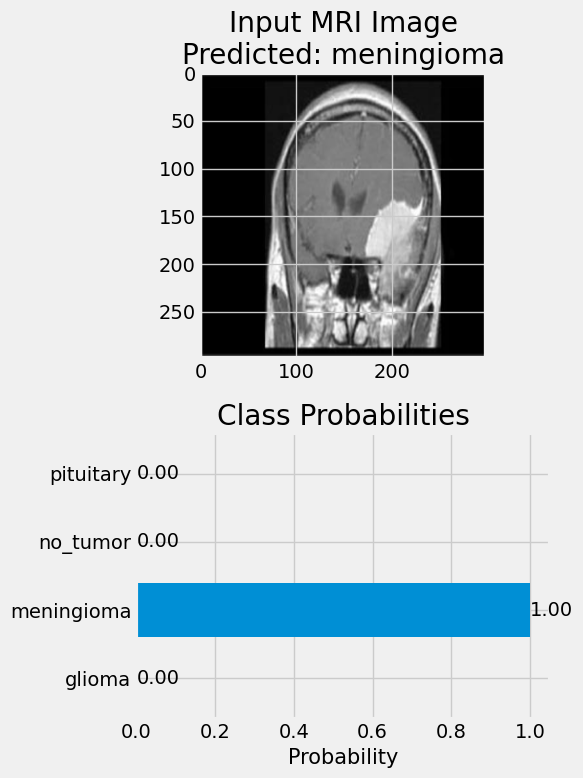


Predicted tumor type: meningioma


In [57]:
predict("../data/Testing/meningioma/Te-meTr_0000.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


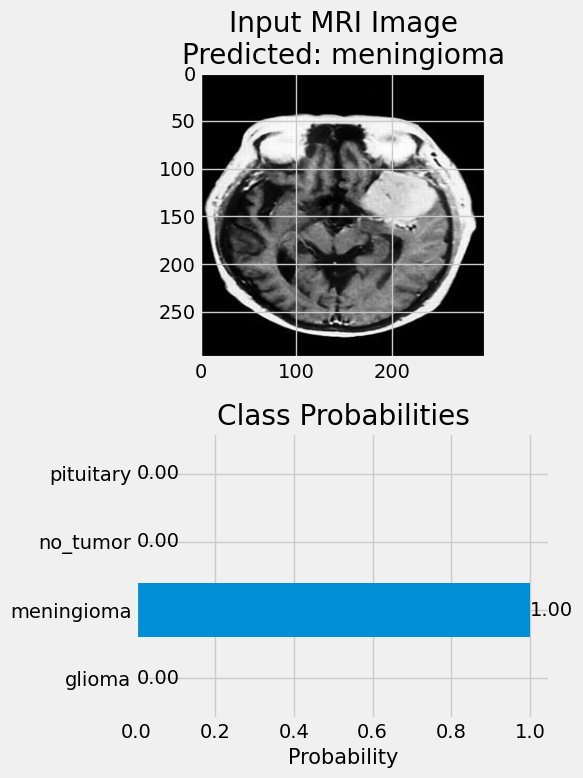


Predicted tumor type: meningioma


In [58]:
predict("../data/Testing/meningioma/Te-meTr_0005.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


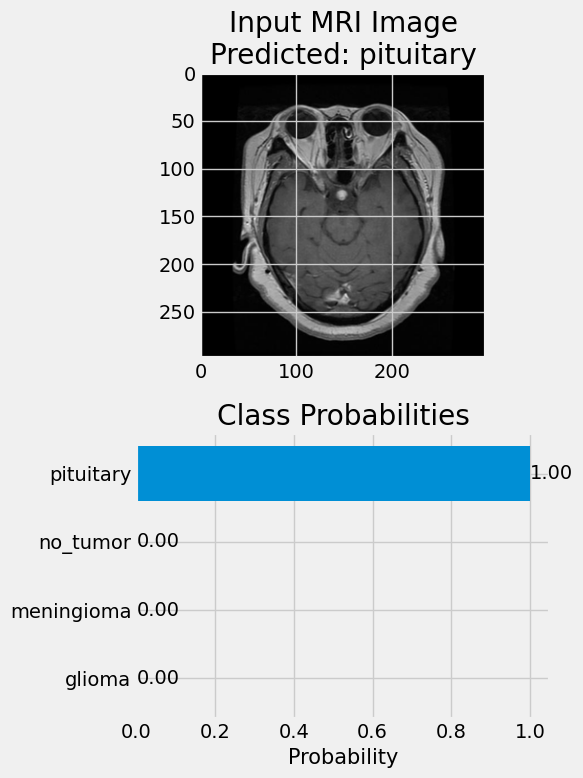


Predicted tumor type: pituitary


In [59]:
predict("../data/Testing/pituitary/Te-pi_0010.jpg")

## Save Model

In [60]:
model.save_weights("xception_model.weights.h5")